### Laboratorium 5 - zadania - transformacja Hougha

In [221]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from skimage.exposure import match_histograms


#### Zadanie 1

Zbadaj wpływ parametrów transformacji Hougha na jakość detekcji prostych na przykładzie obrazu `norway`. Wykorzystaj ulubiony detektor krawędzi i zaprezentuj wyniki pośrednie przed użyciem transformacji Hougha. Zapoznaj się z dokumentacją funkcji [`cv2.HoughLines`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a), zwłaszcza parametrami sterującymi rozdzielczością `rho`, `theta` oraz progiem `threshold`.

Zacznij od znalezienia odpowiednich parametrów detektora krawędzi - jeśli na tym etapie wyniki będą słabe, to dalej będzie tylko gorzej (_garbage-in, garbage-out_) - ale nie skupiaj się na badaniu ich wpływu na wyniki.

Ostateczny rezultat zaprezentuj w postaci odcinków naniesionych na kopię obrazu wejściowego (patrz komórka `[3]`).

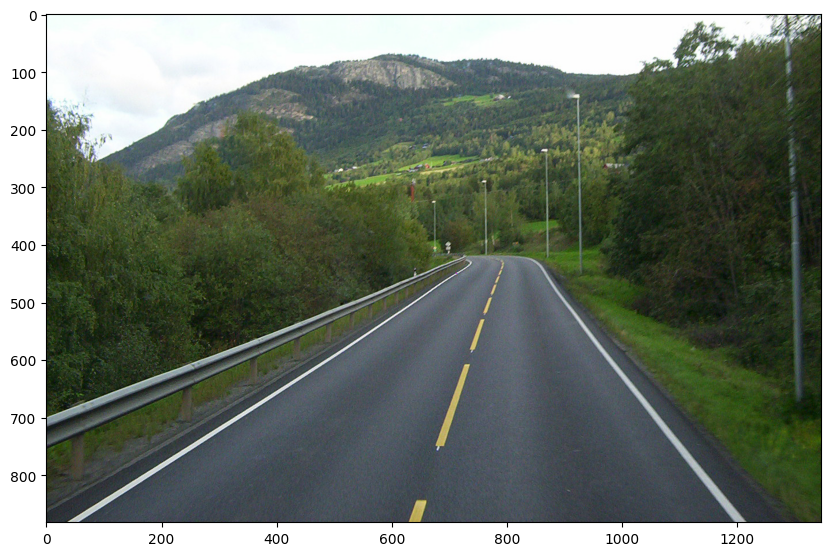

In [222]:
norway = cv2.imread('norway.jpg')
plt.subplots(1, 1, figsize=(10, 10))[1].imshow(norway[..., ::-1]);

In [223]:
def rhotheta2xy(line):
    # konwersja parametrów prostej w układzie rho-theta do odcinka w układzie kartezjańskim
    # wynik można użyć jako argumenty funkcji cv2.line
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 5000 * (-b))
    y1 = int(y0 + 5000 * (a))
    x2 = int(x0 - 5000 * (-b))
    y2 = int(y0 - 5000 * (a))
    return x1, y1, x2, y2

Rozwiązanie:

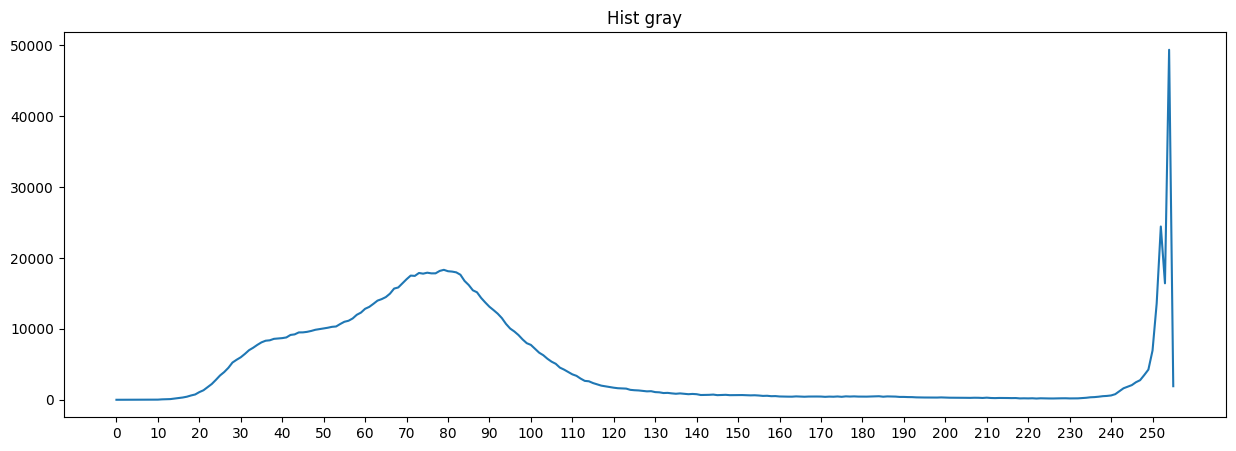

In [224]:
gray = cv2.cvtColor(norway, cv2.COLOR_BGR2GRAY)
hist_gray_plot(gray)

In [225]:

def build_bimodal(size, mean1, mean2, std1, std2, ratio = 0.5):
    x = np.random.normal(mean1, std1, int(size * ratio))
    y = np.random.normal(mean2, std2, int(size * (1 - ratio)))
    return np.concatenate((x, y))

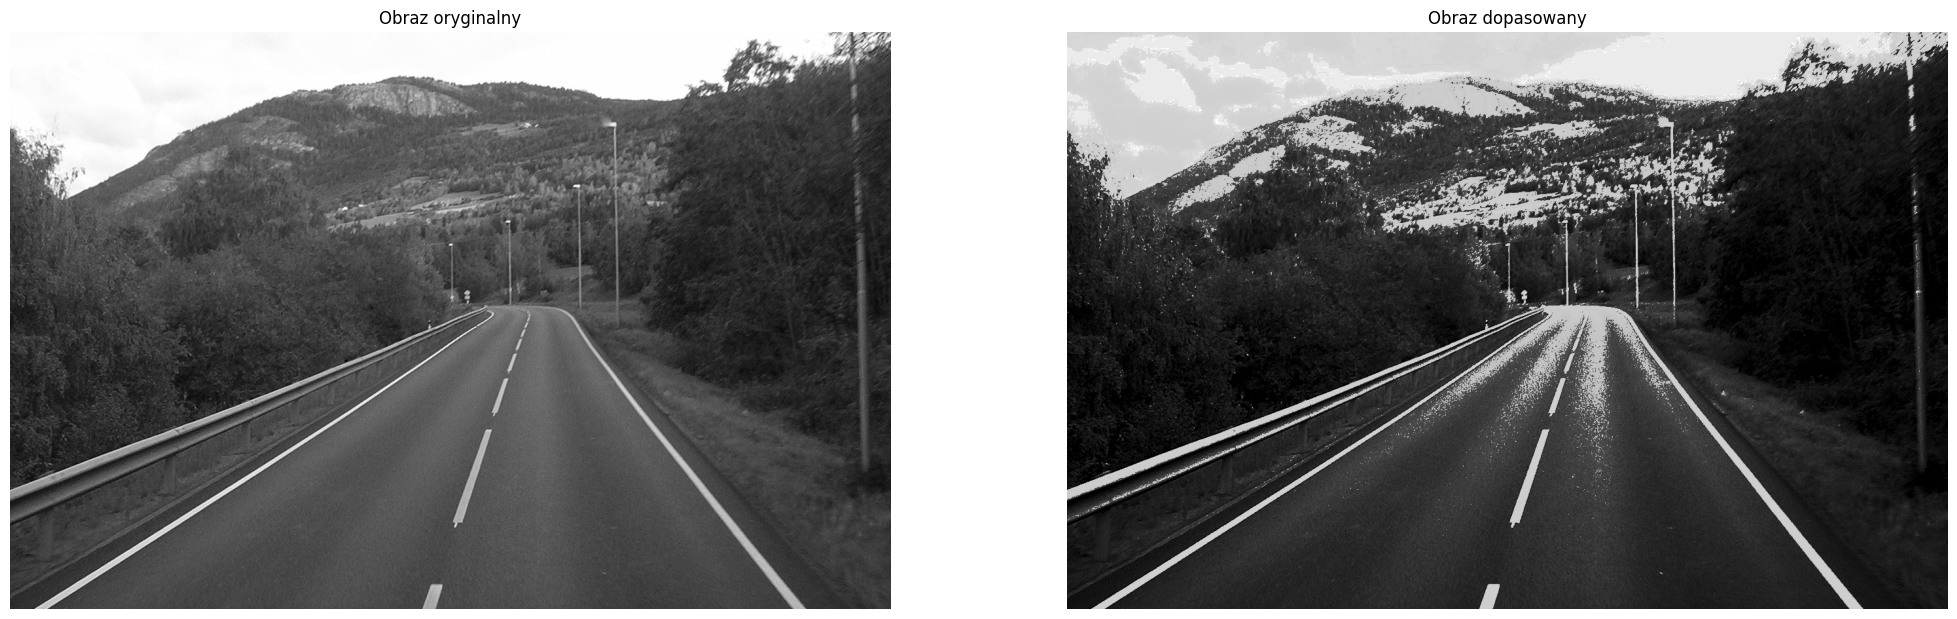

In [226]:
bimodal = build_bimodal(gray.ravel().shape[0], 35, 200, 20, 10, 0.8)
bimodal = np.clip(bimodal, 0, 255).astype(np.uint8)
plt.hist(bimodal, bins=100);
plt.show()
matched = match_histograms(gray.ravel(), bimodal)
matched = matched.reshape(gray.shape)
matched = matched.astype(np.uint8)

display_images([gray, matched], ['Obraz oryginalny', 'Obraz dopasowany'], True)

In [227]:
low, high = (180, 220)
gaus_gray = cv2.GaussianBlur(gray, (7, 7), 0)
gause_edges = cv2.Canny(gaus_gray, low, high)
display_images([gaus_gray, gause_edges], ['Obraz oryginalny', 'Detekcja krawędzi'], True)

gaus_matched = cv2.GaussianBlur(matched, (7, 7), 0)
gause_matched_edges = cv2.Canny(gaus_matched, low, high)
display_images([gaus_matched, gause_matched_edges], ['Obraz oryginalny', 'Detekcja krawędzi'], True)
edges = gause_edges

In [228]:
def plot_lines(img_edges, rho=100, theta=np.pi / 60, threshhold=100, img=None):
    lines = cv2.HoughLines(img_edges, rho, theta, int(threshhold))
    edges_rgb = cv2.cvtColor(img_edges, cv2.COLOR_GRAY2RGB)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = rhotheta2xy(line)
            if img is not None:
                cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
            else:
                cv2.line(edges_rgb, (x1, y1), (x2, y2), (255, 0, 0), 1)
                
    if img is not None:
        return img
    return edges_rgb

# RHO

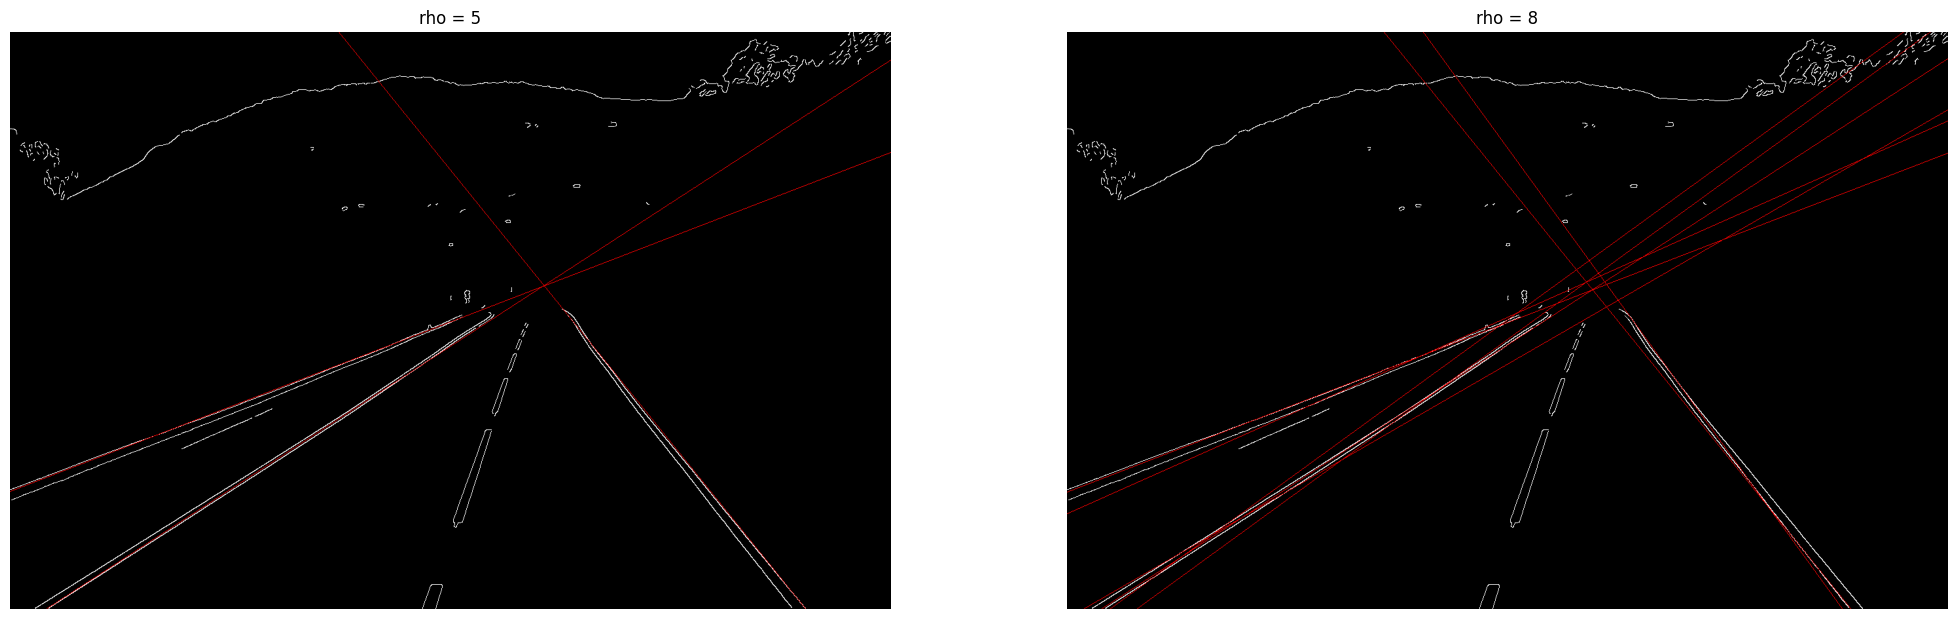

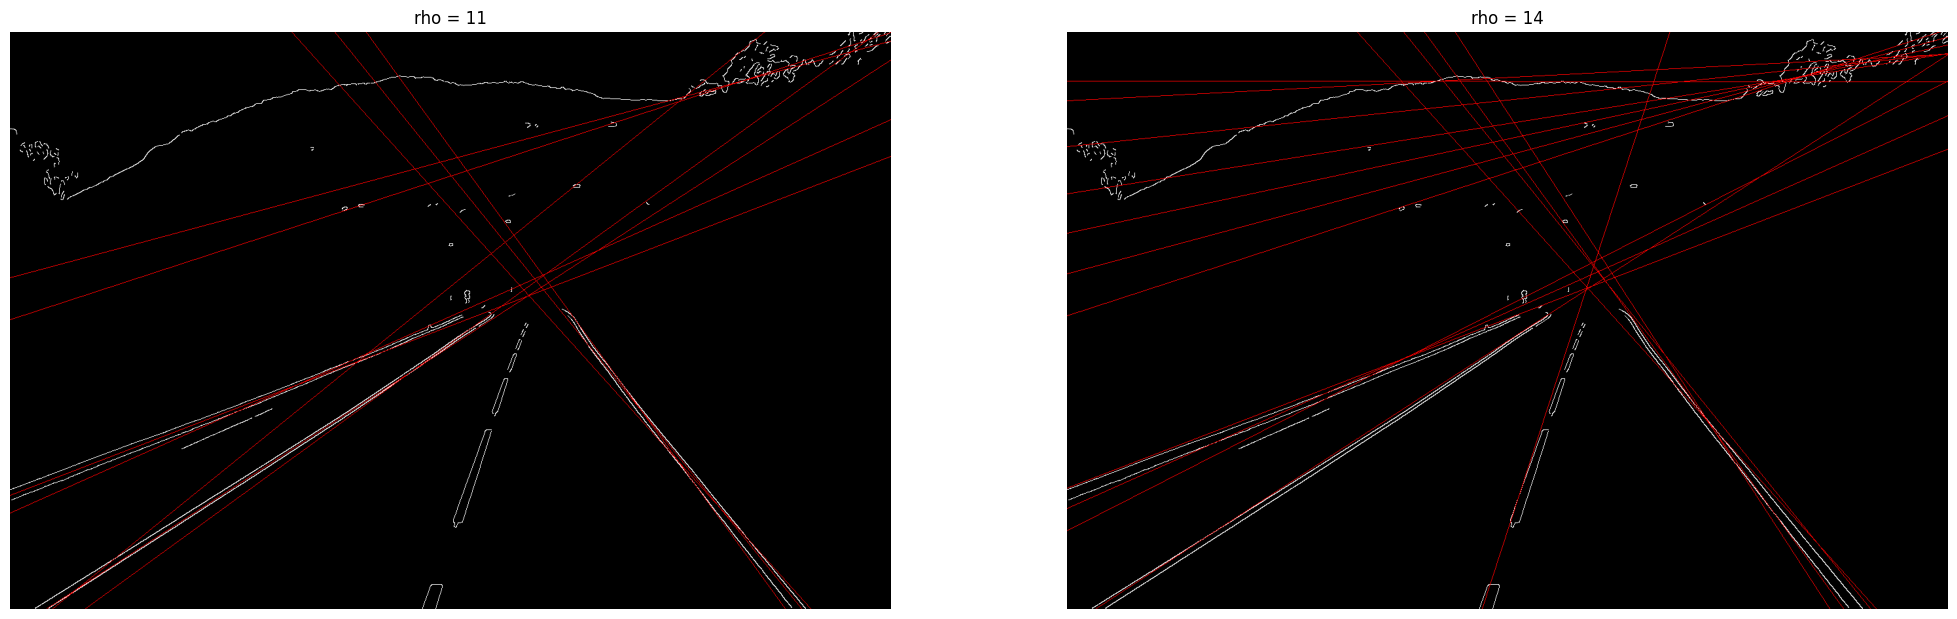

In [229]:
rho = [5, 8, 11, 14, 17]
tests = []
for i, r in enumerate(rho):
    line = plot_lines(edges, r, np.pi / 60, 500)
    tests.append(line)
    if i % 2 == 1:
        display_images(tests, ['rho = ' + str(rho[i - 1]), 'rho = ' + str(rho[i])], True)
        tests = []

# THETA

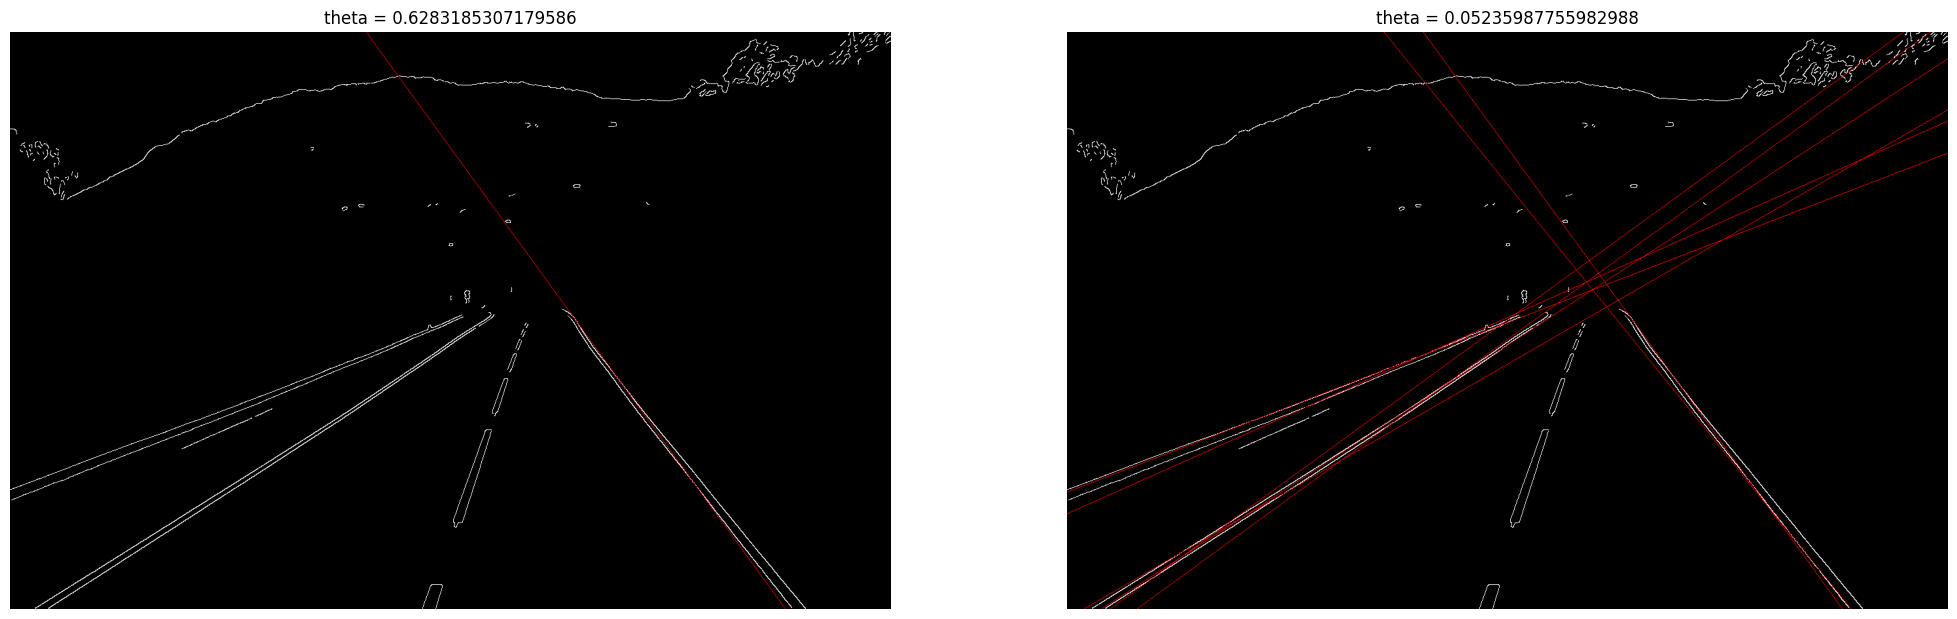

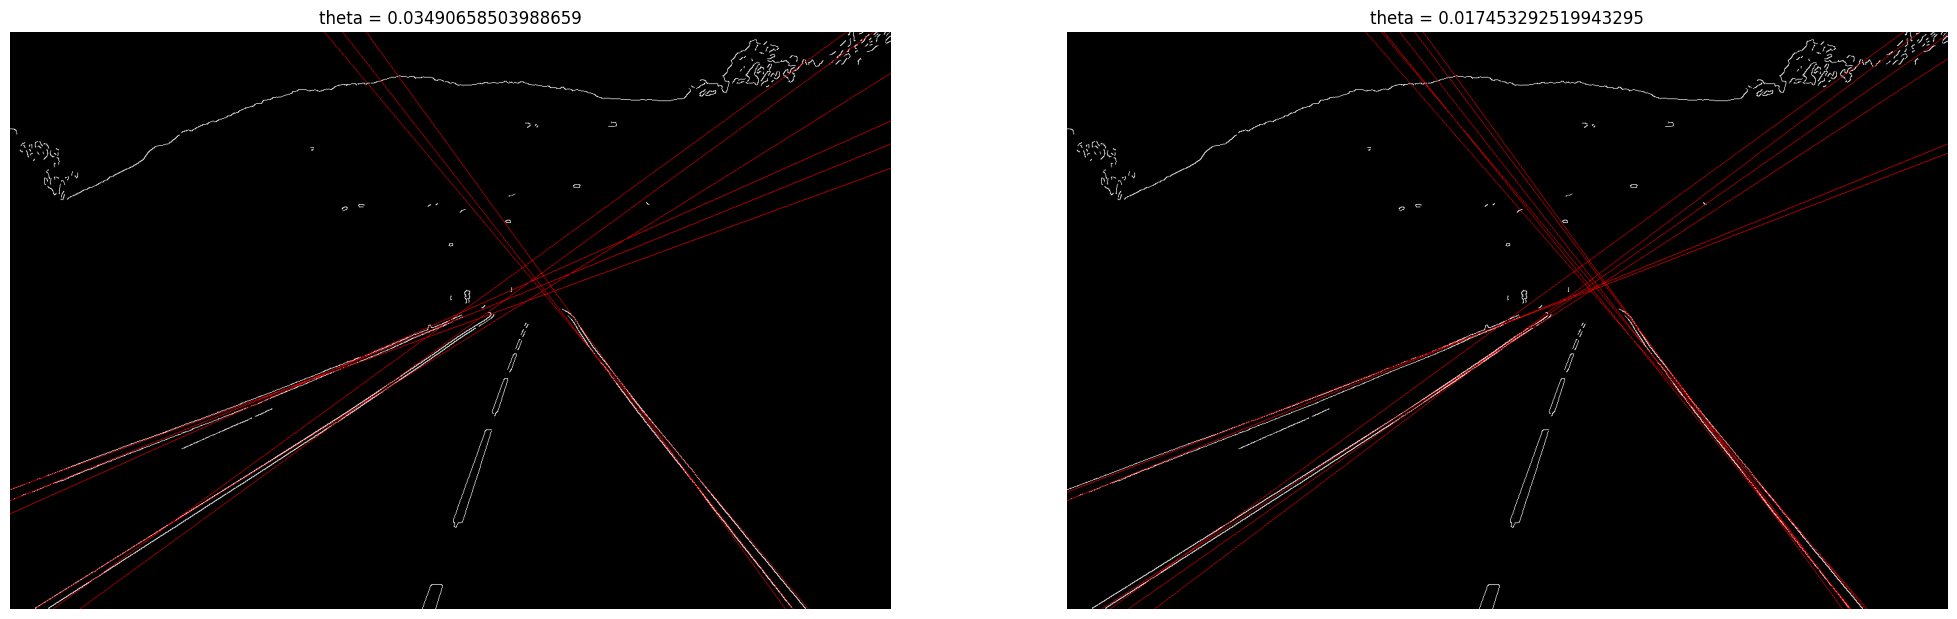

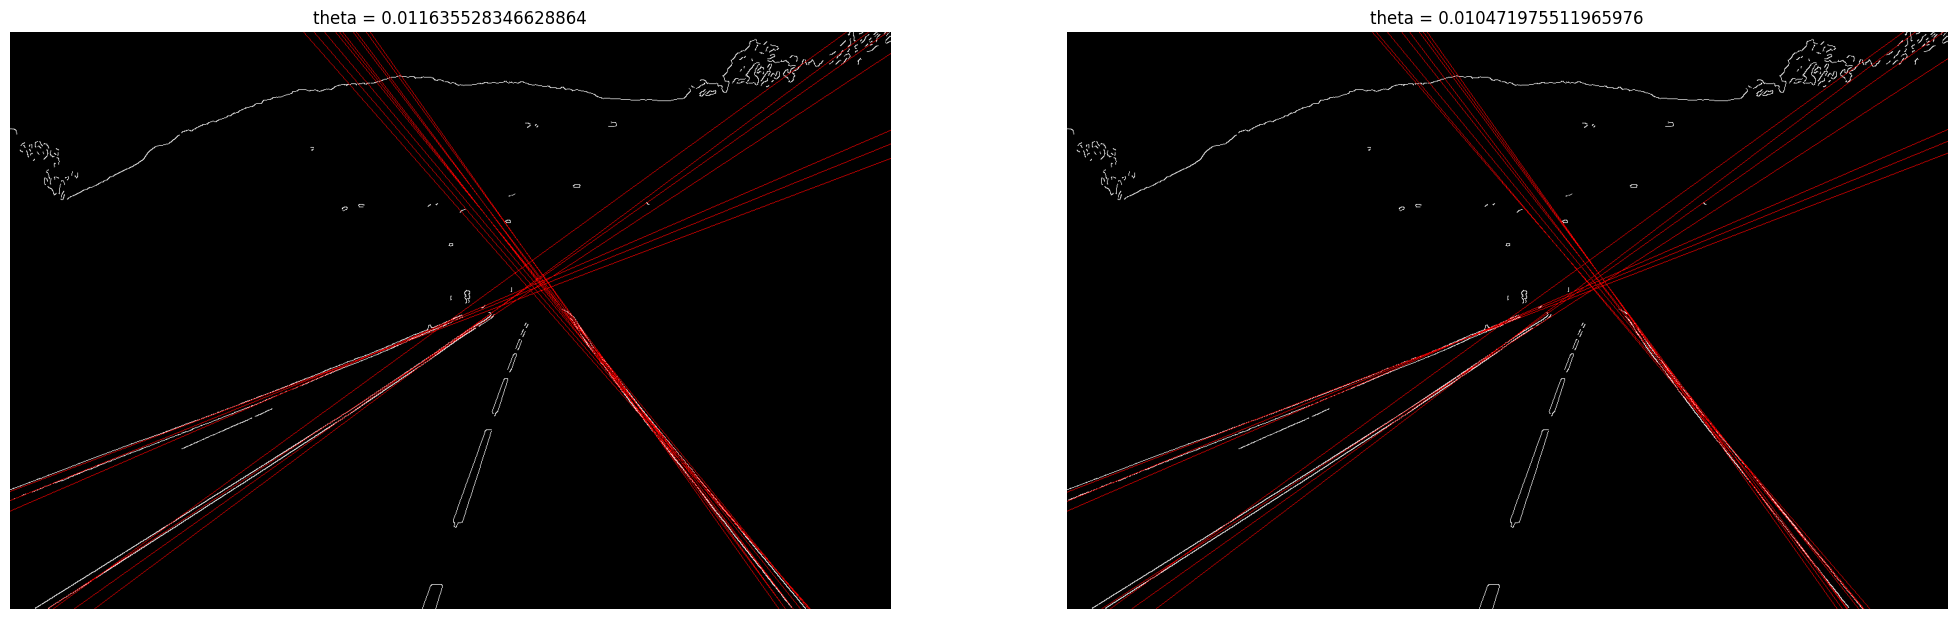

In [230]:
theta = [np.pi / 5, np.pi / 60, np.pi / 90, np.pi / 180, np.pi / 270, np.pi / 300]
tests = []
for i, t in enumerate(theta):
    line = plot_lines(edges, 8, t, 500)
    tests.append(line)
    if i % 2 == 1:
        display_images(tests, ['theta = ' + str(theta[i - 1]), 'theta = ' + str(theta[i])], True)
        tests = []

# THRESHOLD

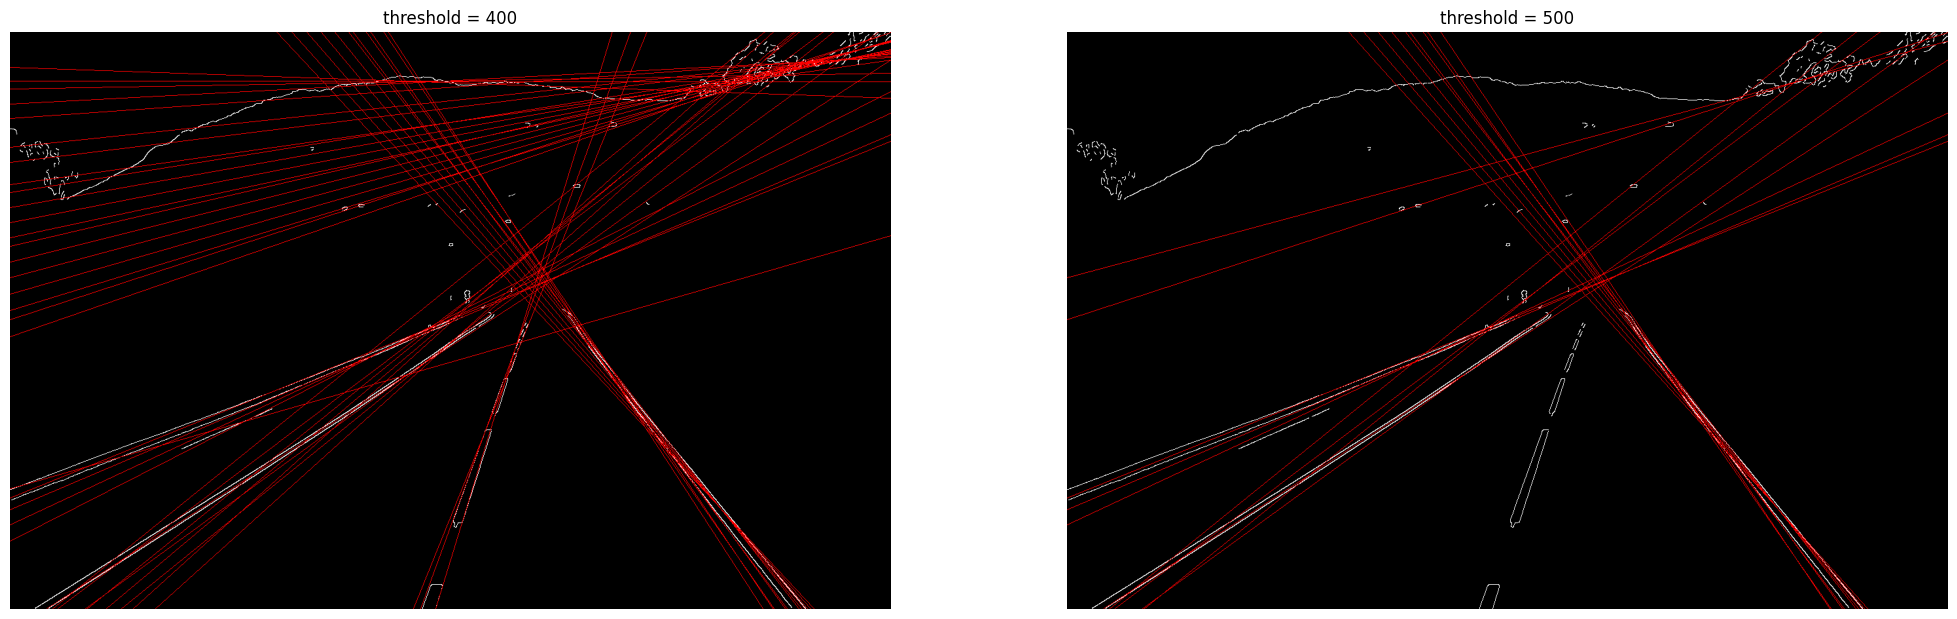

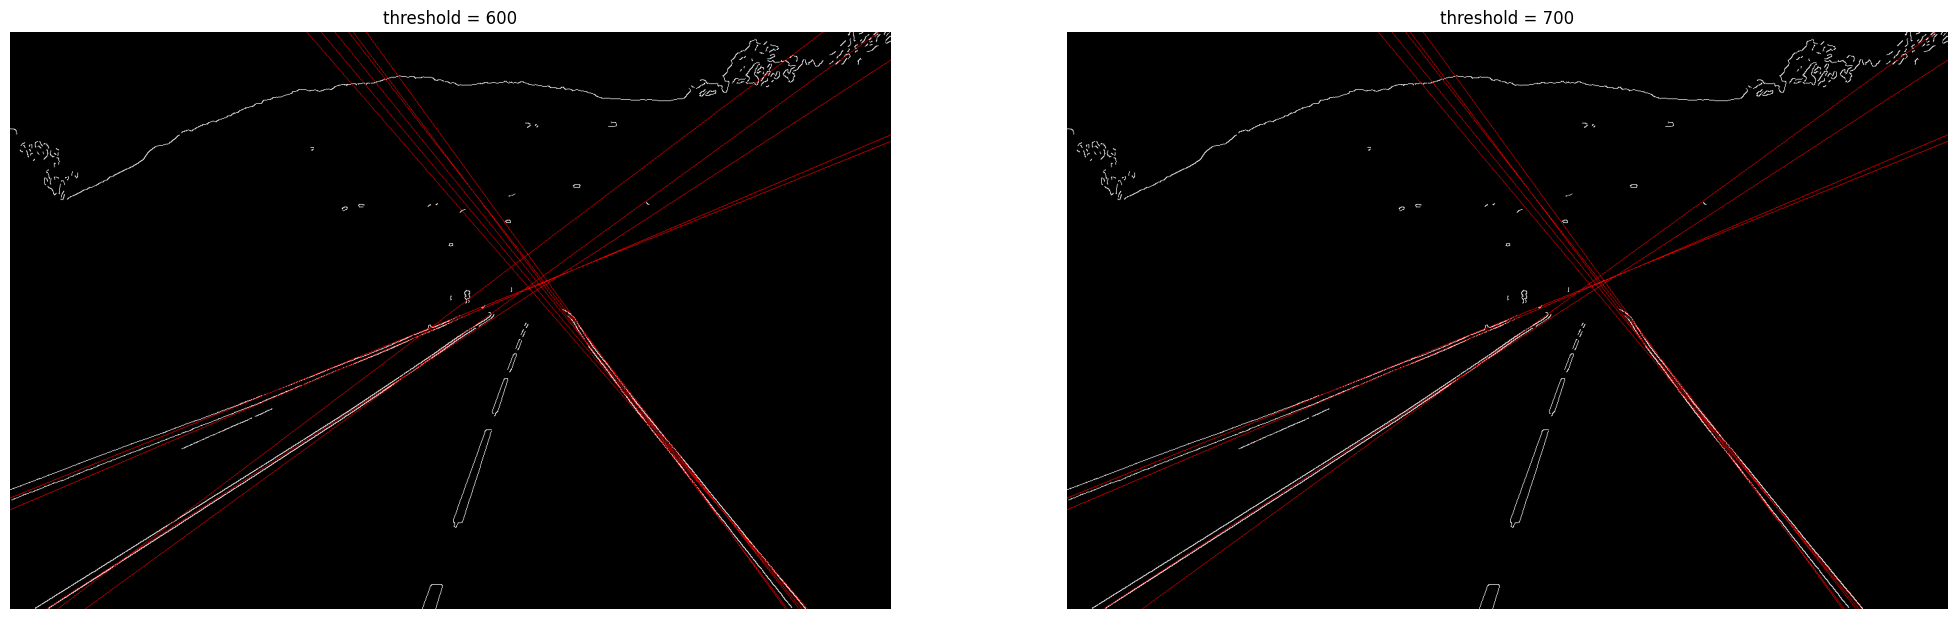

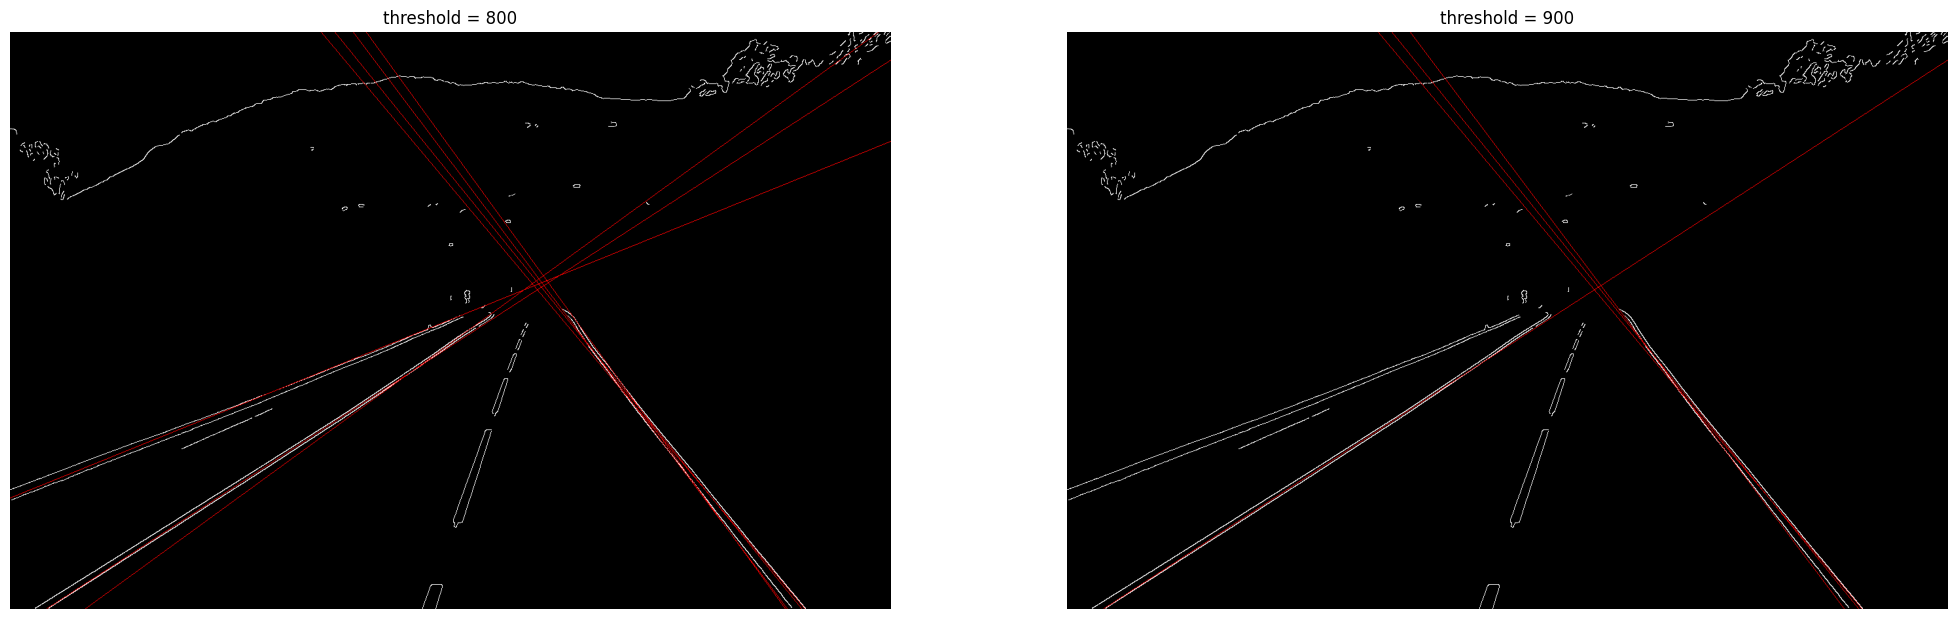

In [231]:
threshold = [400, 500, 600, 700, 800, 900]
tests = []
for i, th in enumerate(threshold):
    line = plot_lines(edges, 11, np.pi / 180, th)
    tests.append(line)
    if i % 2 == 1:
        display_images(tests, ['threshold = ' + str(threshold[i - 1]), 'threshold = ' + str(threshold[i])], True)
        tests = []

#### Zadanie 2

Dany jest obraz `pillbox`. Wykorzystaj transformację Hougha dla prostych, aby wykryć krawędzie między komórkami organizera.

Dla odmiany, w tym zadaniu nie jest istotne badanie parametrów ale wyłącznie końcowy wynik.

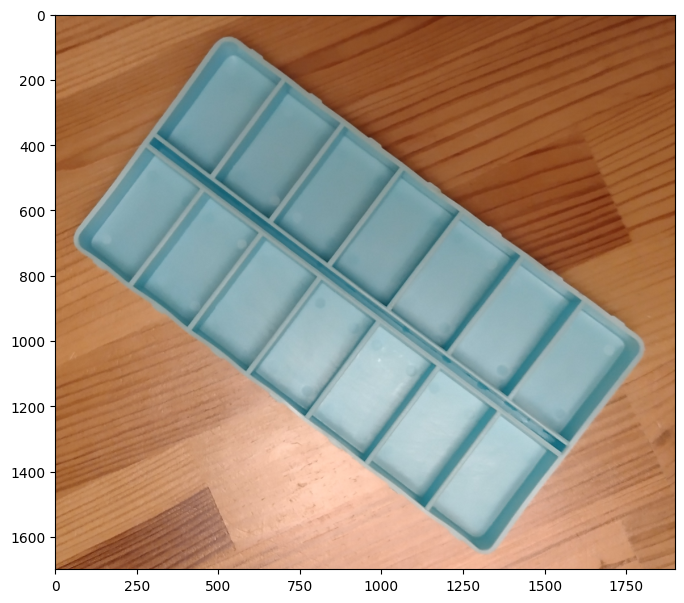

In [232]:
pillbox = cv2.imread('pillbox.png')
pillbox_lab = cv2.cvtColor(pillbox, cv2.COLOR_BGR2LAB)
pillbox_hsv = cv2.cvtColor(pillbox, cv2.COLOR_BGR2HSV)
plt.subplots(1, 1, figsize=(8, 8))[1].imshow(pillbox[..., ::-1]);

Rozwiązanie:

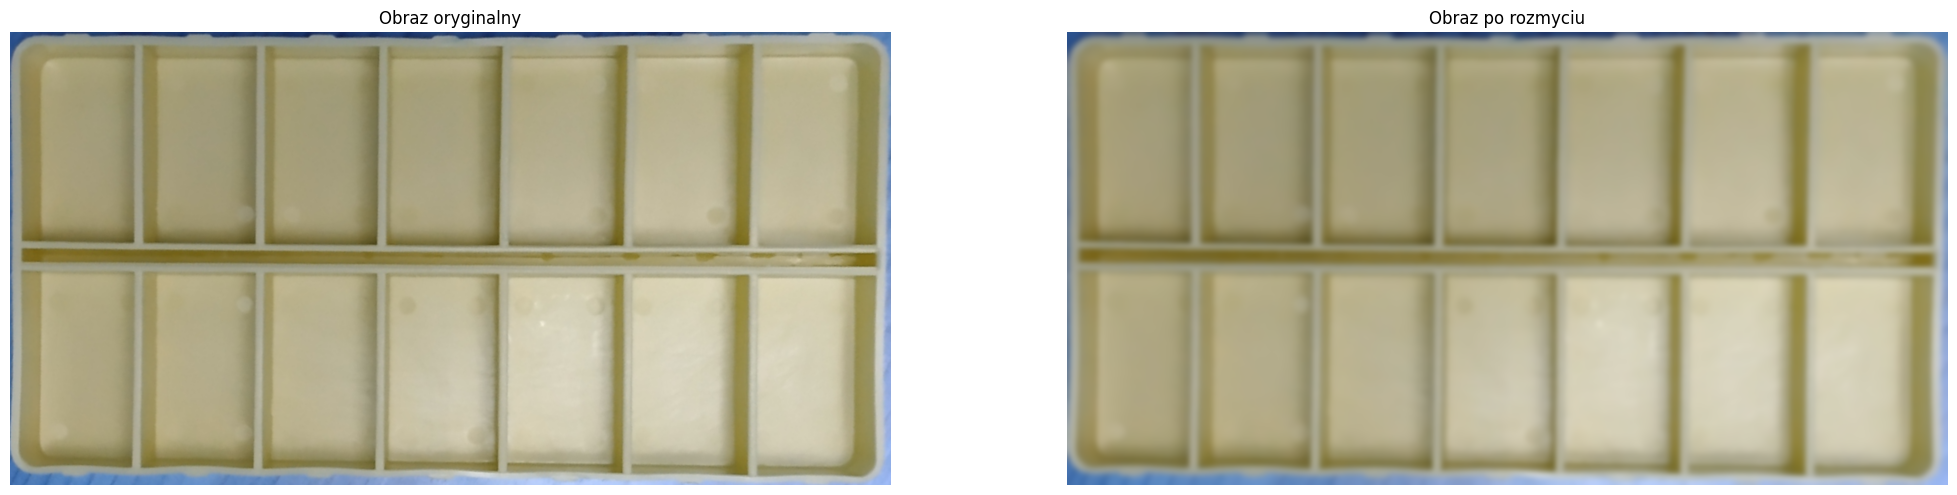

In [233]:
box = crop_box(pillbox, angel=36.5, w = 0, h = 0)
box_blur = cv2.GaussianBlur(box, (29,29), 0)
display_images([box, box_blur], ['Obraz oryginalny', 'Obraz po rozmyciu'], True)

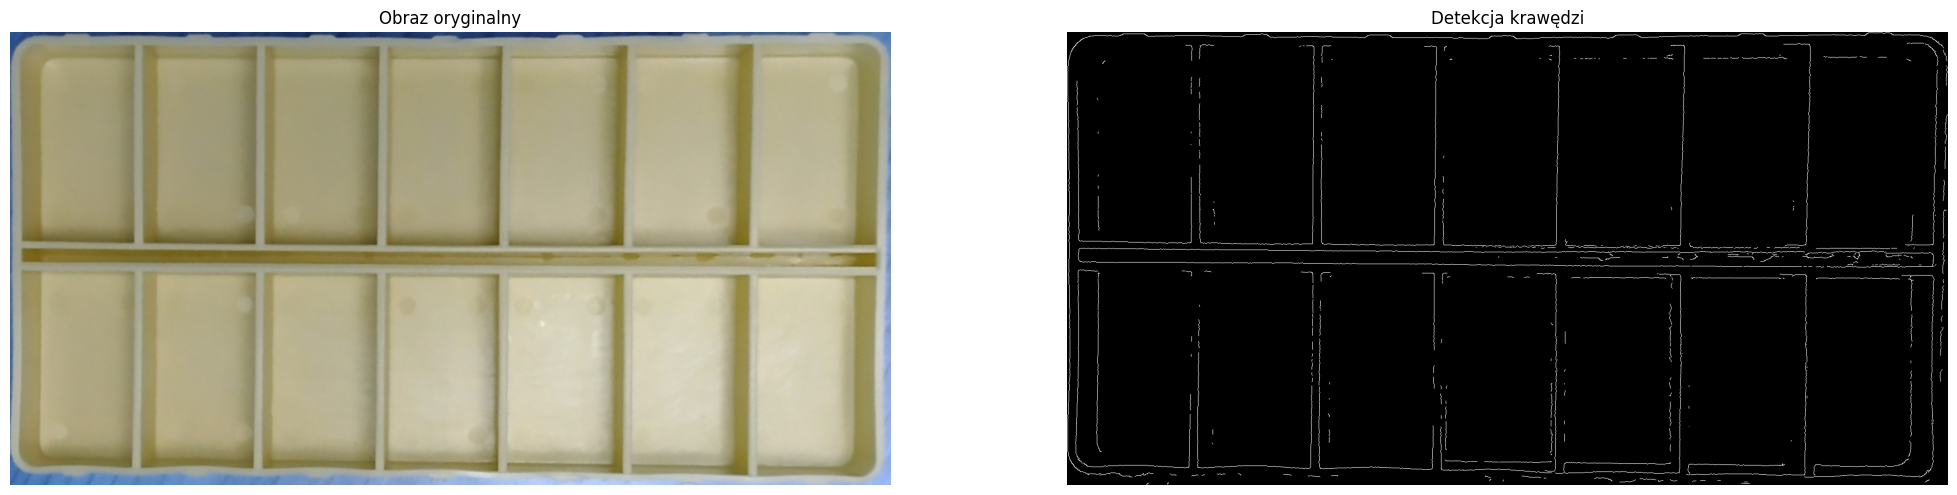

In [234]:
box_edges = cv2.Canny(box, 70, 80)
display_images([box, box_edges], ['Obraz oryginalny', 'Detekcja krawędzi'], True)

In [235]:
box_edges = cv2.Canny(box_blur,20, 25)
display_images([box_blur, box_edges], ['Obraz oryginalny', 'Detekcja krawędzi'], True)

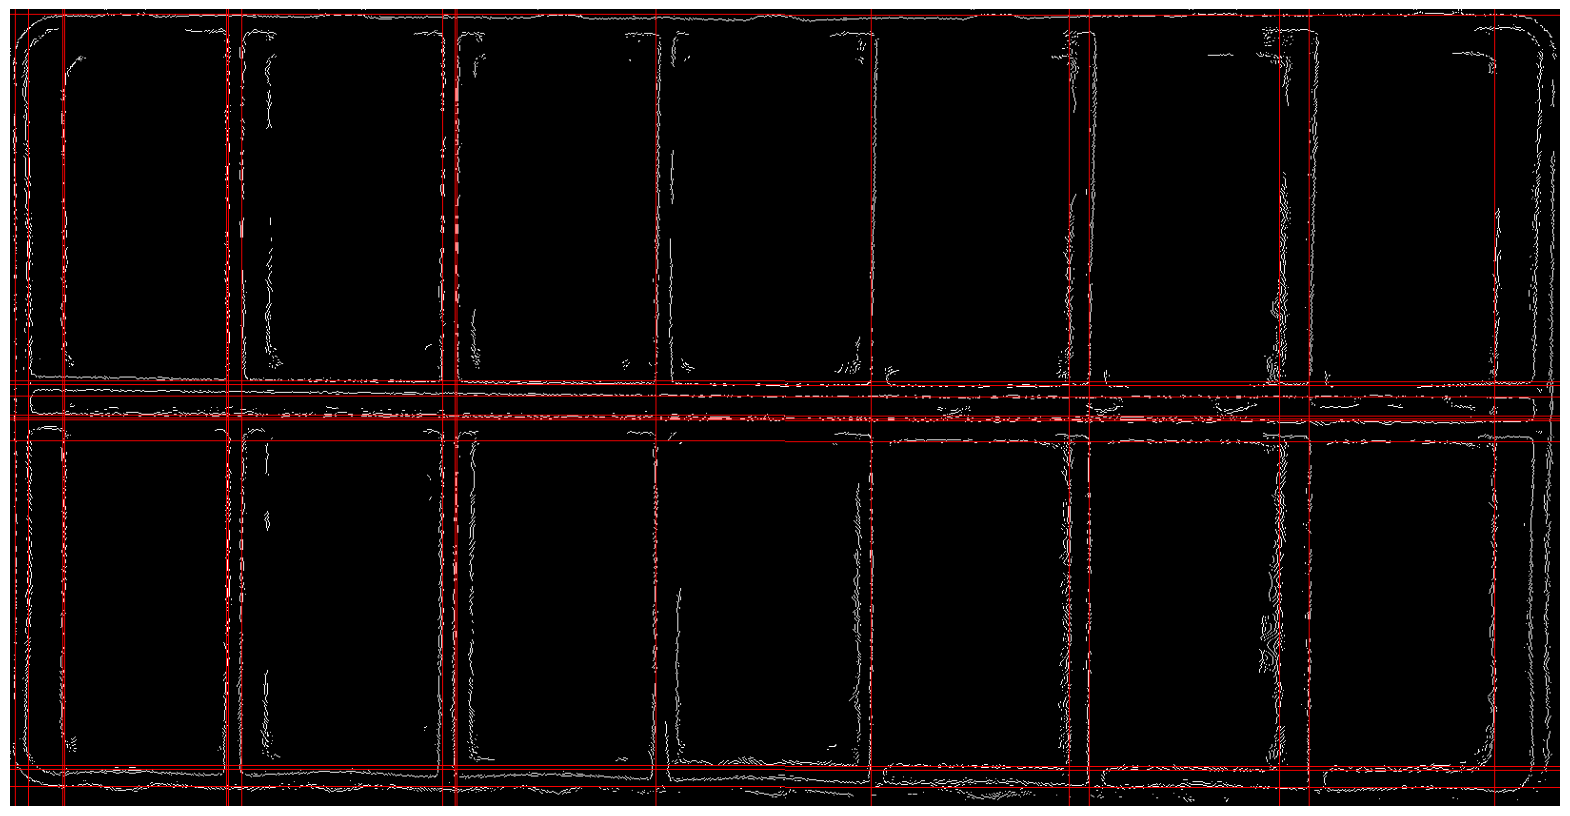

In [236]:
result = plot_lines(box_edges, 1, np.pi / 30, 145, box.copy())
result2 = plot_lines(box_edges, 1, np.pi / 30, 145)
display_images([result], ['Detekcja krawędzi'], True)
display_images([result2], ['Obraz oryginalny'], True)